In [1]:
# %load metamaps.py
"""Provides methods for loading/saving metamaps"""
import struct
from enum import IntEnum
from keras.utils import Sequence
import numpy as np
import os
import random

METAMAP_FILE_VERSION = 0x100

class TileType(IntEnum):
    """Tile types in a metamap"""
    UNREACHABLE = 0
    EMPTY = 1
    WALL = 2
    PUSHWALL = 3
    DOOR = 4


class EncodingDim(IntEnum):
    """Dimensions for the one-hot encoding of a metamap"""
    PLAYABLE = 0
    SOLID = 1
    PASSAGE = 2


class MetaMapsSequence(Sequence):
    """A sequence of real metamaps from a directory and randomly generated ones"""

    def __init__(self, maps_dir, batch_size):
        self.maps_dir = maps_dir
        self.batch_size = batch_size
        self.map_files = os.listdir(maps_dir)
        NUM_MAPS = len(self.map_files)
        real_maps = [(index, True) for index in range(NUM_MAPS)]
        fake_maps = [(index + NUM_MAPS, False) for index in range(NUM_MAPS)]
        map_order = real_maps + fake_maps
        np.random.shuffle(map_order)
        self.map_order = map_order

    def __len__(self):
        return int(len(self.map_order) / self.batch_size)

    def __getitem__(self, idx):
        map_batch = np.zeros((self.batch_size, 64, 64, len(EncodingDim)))
        label_batch = np.zeros((self.batch_size))

        for i in range(self.batch_size):
            (index, real_map) = self.map_order[idx * self.batch_size + i]
            if real_map:
                label_batch[i] = 1
                map_batch[i:] = load_metamap(
                    os.path.join(self.maps_dir, self.map_files[index]))
            else:
                map_batch[i:] = generate_random_map()

        return map_batch, label_batch


def generate_random_map():
    """Generate a random map"""
    width = 64
    height = 64
    size = width * height

    junk_map = np.zeros([size, len(EncodingDim)])

    for i in range(size):
        tile_type = random.randint(0, len(EncodingDim) - 1)
        junk_map[i, tile_type] = 1

    junk_map.shape = (width, height, len(EncodingDim))

    return junk_map


def load_all_metamaps(dirname):
    """Loads all the metamaps in the given directory, returning a giant numpy array"""
    map_names = os.listdir(dirname)
    all_maps = np.zeros((len(map_names), 64, 64, len(EncodingDim)))

    for index, map_name in enumerate(map_names):
        load_metamap_into(os.path.join(dirname, map_name), all_maps, index)

    return all_maps


def load_metamap_into(filename, all_maps, index):
    """Loads a metamap from a file into a numpy array of shape (width, height, 3)"""
    with open(filename, "rb") as fin:
        version = struct.unpack('Q', fin.read(8))[0]

        if version != METAMAP_FILE_VERSION:
            raise ValueError("Unsupported metamap version")

        width = struct.unpack('i', fin.read(4))[0]
        height = struct.unpack('i', fin.read(4))[0]

        raw_map = np.fromfile(fin, dtype=np.uint8)
        raw_map.shape = (width, height)

        for y in range(height):
            for x in range(width):
                tile_type = TileType(raw_map[y, x])
                if tile_type == TileType.EMPTY:
                    all_maps[index, y, x, EncodingDim.PLAYABLE] = 1
                elif tile_type == TileType.UNREACHABLE or tile_type == TileType.WALL:
                    all_maps[index, y, x, EncodingDim.SOLID] = 1
                elif tile_type == TileType.PUSHWALL or tile_type == TileType.DOOR:
                    all_maps[index, y, x, EncodingDim.PASSAGE] = 1


def load_metamap(filename):
    """Loads a metamap from a file into a numpy array of shape (width, height, 3)"""
    with open(filename, "rb") as fin:
        version = struct.unpack('Q', fin.read(8))[0]

        if version != METAMAP_FILE_VERSION:
            raise ValueError("Unsupported metamap version")

        width = struct.unpack('i', fin.read(4))[0]
        height = struct.unpack('i', fin.read(4))[0]
        size = width * height

        raw_map = np.fromfile(fin, dtype=np.uint8)
        one_hot = np.zeros([size, len(EncodingDim)])

        for i in range(size):
            tile_type = TileType(raw_map[i])
            if tile_type == TileType.EMPTY:
                one_hot[i, EncodingDim.PLAYABLE] = 1
            elif tile_type == TileType.UNREACHABLE or tile_type == TileType.WALL:
                one_hot[i, EncodingDim.SOLID] = 1
            elif tile_type == TileType.PUSHWALL or tile_type == TileType.DOOR:
                one_hot[i, EncodingDim.PASSAGE] = 1

        one_hot.shape = (width, height, len(EncodingDim))

        return one_hot


def save_metamap(metamap, filename):
    """Saves a metamap to a file"""
    with open(filename, "wb") as fout:
        fout.write(struct.pack('Q', METAMAP_FILE_VERSION))

        width = metamap.shape[0]
        height = metamap.shape[1]

        fout.write(struct.pack('i', width))
        fout.write(struct.pack('i', height))
        for y in range(height):
            for x in range(width):
                tile_type = TileType.WALL
                if metamap[y, x, EncodingDim.PLAYABLE] == 1:
                    tile_type = TileType.EMPTY
                elif metamap[y, x, EncodingDim.SOLID] == 1:
                    tile_type = TileType.WALL
                elif metamap[y, x, EncodingDim.PASSAGE] == 1:
                    tile_type = TileType.DOOR

                fout.write(struct.pack('b', tile_type))
    return

C:\Users\david\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

In [3]:
map_shape = (64, 64, len(EncodingDim))
latent_dim = 2  # Dimensionality of the latent space: a plane

# Custom Loss Class

In [4]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# Encoder

In [31]:
input_map = keras.Input(shape=map_shape)

# keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
x = layers.Conv2D(32, 3, 
                  padding='same', 
                  activation='relu')(input_map)

x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2,2))(x)

x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2,2))(x)

x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling function

In [32]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder

In [33]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(len(EncodingDim), 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [34]:
shape_before_flattening

(None, 16, 16, 64)

In [36]:
# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_map, z_decoded])

# Create Model

In [37]:
vae = Model(input_map, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 64, 64, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 64)   18496       conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   36928       conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_16 

C:\Users\david\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Output "custom_variational_layer_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_4" during training.
  from ipykernel import kernelapp as app


# Load all maps

In [10]:
import time

t0 = time.perf_counter()
all_maps = load_all_metamaps("metamaps")
t1 = time.perf_counter()
time_spent_loading = t1 - t0

In [11]:
time_spent_str = time.strftime("%H:%M:%S", time.gmtime(time_spent_loading))
print(f"Loaded all maps in {time_spent_str}")

Loaded all maps in 00:11:05


In [12]:
print(f"all_maps.shape = {all_maps.shape}")

all_maps.shape = (34257, 64, 64, 3)


In [13]:
batch_size = 20

all_maps_len = all_maps.shape[0]
all_maps_len = all_maps_len - (all_maps_len % batch_size)

print(all_maps_len)

34240


In [14]:
batches = int(all_maps_len/batch_size)
test_size = int((1/7)*batches) * batch_size
print(test_size)

4880


In [15]:
train_size = all_maps_len - test_size

In [16]:
train_maps = all_maps[:train_size, :, :, :]
test_maps = all_maps[train_size:(train_size+test_size), :, :, :]
print("Train shape: ",train_maps.shape)
print("Test shape:  ",test_maps.shape)

Train shape:  (29360, 64, 64, 3)
Test shape:   (4880, 64, 64, 3)


# Training!

In [39]:
history = vae.fit(
    x=train_maps, y=None,
    shuffle=False,
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_maps, None))

Train on 29360 samples, validate on 4880 samples
Epoch 1/2
29360/29360 [==============================] - 713s 24ms/step - loss: 0.3882 - val_loss: 0.3689
Epoch 2/2
29360/29360 [==============================] - 729s 25ms/step - loss: 0.3670 - val_loss: 0.3699


# Show Output

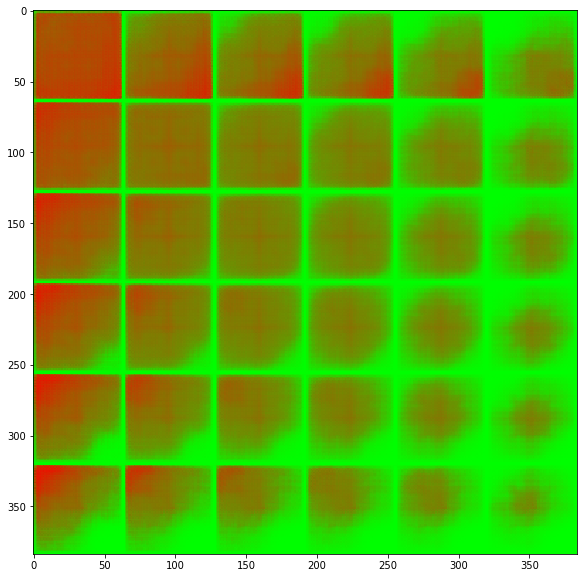

In [42]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the maps
n = 6
map_size = 64
figure = np.zeros((map_size * n, map_size * n, len(EncodingDim)))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        metamap = x_decoded[0].reshape(map_size, map_size, len(EncodingDim))
        figure[i * map_size: (i + 1) * map_size,
               j * map_size: (j + 1) * map_size] = metamap

plt.figure(figsize=(10, 10))
plt.imshow(figure, interpolation='nearest')
plt.show()